# Identifying parts of recipe ingredients

We're going to use transformers to train a recipe tagger. We will follow the techniques used in the [Jupyter Notebook xlm-roberta-base-finetuned-recipe-all](https://github.com/EdwardJRoss/nlp_transformers_exercises/blob/master/notebooks/ch4-ner-recipe-xlm-roberta.ipynb).

We will use the data from [English Recipe Flowgraph](https://sites.google.com/view/yy-lab/resource/english-recipe-flowgraph?authuser=0).

In [1]:
push_to_hub = False

from huggingface_hub import notebook_login

if push_to_hub:
    notebook_login()

The data is a text file where each line is separated by a space.   The first three numbers show the number of the step, the number of the sentence in the step, and the number of word in the sentence. The fourth token shows the corresponding word, the fifth token shows POS tag automatically labeled with the parsing system RASP, and the last token shows manually labeled r-NE tag.

We'll convert this into a list of pairs of text, token.

In [2]:
sample="""	
1 1 1 Preheat VV0 Ac-B
1 1 9 the AT O
1 1 13 oven NN1 T-B
1 1 18 to II O
1 1 21 170 MC St-B
1 1 25 C ZZ1 St-I
1 1 27 / CC O
1 1 29 Gas NN1 St-B
1 1 33 mark NN1 St-I
1 1 38 3 MC St-I
1 1 40 . . O
1 2 1 Brush NP1 Ac-B
1 2 7 around II O
1 2 14 22cm NP1 St-B
1 2 19 ( ( O
1 2 21 base NN1 St-B
1 2 26 measurement NN1 St-I
1 2 38 ) ) O
1 2 40 cake NN1 T-B
1 2 45 tin NN1 T-I
1 2 49 with IW O
1 2 54 melted VVN Ac-B
1 2 61 butter NN F-B
1 2 68 to TO O
1 2 71 grease VV0 Ac-B
1 2 78 . . O
1 3 1 Line NP1 Ac-B
1 3 6 base NN1 T-B
1 3 11 and CC O
1 3 15 side NN1 T-B
1 3 20 with IW O
1 3 25 baking NN1 T-B
1 3 32 parchment NN1 T-I
1 3 42 . . O
"""

In [3]:
from typing import List, Tuple

def segment_texts(data: str) -> List[Tuple[str, str]]:
    sentences = []
    sentence = []
    for line in data.split('\n'):
        line = line.strip()
        if line:
            item_list = line.split(' ')
            text = item_list[3]
            tag = item_list[-1]
            sentence.append((text.strip(), tag.strip()))
            if text == '.' and tag == 'O':
                sentences.append(sentence)
                sentence = []
    return sentences
            

In [4]:
for line in segment_texts(sample):
    print(line)

[('Preheat', 'Ac-B'), ('the', 'O'), ('oven', 'T-B'), ('to', 'O'), ('170', 'St-B'), ('C', 'St-I'), ('/', 'O'), ('Gas', 'St-B'), ('mark', 'St-I'), ('3', 'St-I'), ('.', 'O')]
[('Brush', 'Ac-B'), ('around', 'O'), ('22cm', 'St-B'), ('(', 'O'), ('base', 'St-B'), ('measurement', 'St-I'), (')', 'O'), ('cake', 'T-B'), ('tin', 'T-I'), ('with', 'O'), ('melted', 'Ac-B'), ('butter', 'F-B'), ('to', 'O'), ('grease', 'Ac-B'), ('.', 'O')]
[('Line', 'Ac-B'), ('base', 'T-B'), ('and', 'O'), ('side', 'T-B'), ('with', 'O'), ('baking', 'T-B'), ('parchment', 'T-I'), ('.', 'O')]


Converting to IOB-1.

Because this isn't in the text itself we're going to infer any adjacent tags are a compound; this may not be true.

In [5]:
def convert_to_iob1(tokens):
    return ['I-' + label.replace('-B', '').replace('-I', '') if label != 'O' else 'O' for label in tokens]

assert convert_to_iob1(['Ac-B', 'Ac-I', 'D-I', 'F-B', 'O']) == ['I-Ac', 'I-Ac', 'I-D', 'I-F', 'O']

In [6]:
iob_names = ['I-Ac', 'I-Ac2', 'I-Af', 'I-At', 'I-D', 'I-F', 'O', 'I-Q', 'I-Sf', 'I-St', 'I-T']

Read the dataset files from disk.

In [7]:
import glob
import random
from os.path import join

data_sources = ['r-100', 'r-200']
data_splits = ['train', 'validation', 'test']
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15
path_dataset = '/Users/rlopez/PTG/experiments/datasets/EnglishFlowGraph/' # You have to request the dataset to the authors

def read_data(source, split):
    file_names = glob.glob(join(path_dataset, '%s/*.list' % source))
    random.seed(0)
    random.shuffle(file_names)
    size = len(file_names)
    if split == 'train':
        file_names = file_names[:int(size*train_ratio)]
    elif split == 'validation':
        file_names = file_names[int(size*train_ratio):int(size*(train_ratio+validation_ratio))]
    elif split == 'test':
        file_names = file_names[:int(size*test_ratio)]
        
    recipes = []

    for file_name in file_names:
        with open(file_name) as fin:
            recipe = fin.read()
            recipes += segment_texts(recipe)
     
    return recipes

Then we want to wrap this in a HuggingFace dataset.

This requires flipping them into aligned sequences of tokens and labels, which we can do with `zip(*...)`.

In [8]:
from datasets import Dataset, Features, Sequence, Value, ClassLabel

_features = Features(
    tokens=Sequence(Value(dtype='string')),
    labels=Sequence(ClassLabel(names=iob_names))
)

def convert_to_dataset(data):
    all_tokens = []
    all_labels = []
    for datum in data:
        tokens, labels = zip(*datum)
        all_tokens.append(tokens)
        all_labels.append(convert_to_iob1(labels))
        
    return Dataset.from_dict({'tokens': all_tokens, 'labels': all_labels},
                             _features)

Then we can wrap it all together to get the datasets.

In [9]:
from datasets import DatasetDict

data = {source: DatasetDict({split: convert_to_dataset(read_data(source, split)) for split in data_splits}) for source in data_sources}

In [10]:
data['r-100']['train'][0]

{'tokens': ['Place',
  'the',
  'chicken',
  ',',
  'carrots',
  ',',
  'celery',
  'and',
  'onion',
  'in',
  'a',
  'large',
  'soup',
  'pot',
  ';',
  'cover',
  'with',
  'cold',
  'water',
  '.'],
 'labels': [0, 6, 5, 6, 5, 6, 5, 6, 5, 6, 6, 9, 10, 10, 6, 0, 6, 8, 5, 6]}

We can show the dataset sizes

In [11]:
import pandas as pd

(
    pd.DataFrame(
        [(source, split, len(datum)) for source, source_data in data.items() for split, datum in source_data.items()],
        columns=['source', 'split', 'n'])
    .pivot(index='split', columns='source', values='n')
    .sort_values('r-100', ascending=False)
    .assign(both = lambda _: _.sum(axis=1))
)

source,r-100,r-200,both
split,,,
train,674,1283,1957
validation,150,246,396
test,148,304,452


# Examining data

## Tags

In [12]:
tag_feature = data['r-100']['train'].features['labels'].feature

We need a little helper function to convert the integer labels into a Pandas categorical dtype.

In [13]:
def convert_int_to_categorical(df: pd.DataFrame, col_name: str, names: List[str], copy=True) -> pd.DataFrame:
    if copy:
        df = df.copy()
    int2str = dict(enumerate(names))
    df[col_name] = df[col_name].map(int2str)
    df[col_name] = pd.Categorical(df[col_name], categories=names)
    return df

In [14]:
df_train = (pd.concat([pd.DataFrame(data[source]['train']).assign(source=source) for source in data_sources],
                      ignore_index=True)
            .apply(lambda _: _.explode())
            .pipe(convert_int_to_categorical, 'labels', tag_feature.names)
            .reset_index()
           )

df_train.head()

,index,tokens,labels,source
0,0,Place,I-Ac,r-100
1,0,the,O,r-100
2,0,chicken,I-F,r-100
3,0,",",O,r-100
4,0,carrots,I-F,r-100


## How frequent are the tags?

In [15]:
df_tag_count = (
    df_train
    .groupby(['source', 'labels'])
    .agg(n=('index', 'count'))
    .reset_index()
    .pivot('labels', 'source', 'n')
    .sort_values(data_sources[0], ascending=False)
)
df_tag_count

source,r-100,r-200
labels,,
O,4455,8517
I-F,1549,2699
I-Ac,1375,2560
I-T,617,1104
I-D,409,747
I-St,328,563
I-Sf,308,652
I-Q,175,263
I-Af,87,141


We can see 'I-At'(action by tool) and 'I-Ac2' (discontinous action) a are pretty uncommon and it will be hard to do well on them.

<AxesSubplot:ylabel='labels'>

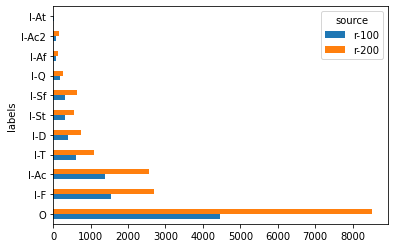

In [16]:
df_tag_count.plot.barh()

Another way to view it is how many sentences have each kind of tag,

Almost every example has a action (as it should)

In [17]:
df_tag_sentence_count = (
    df_train
    .groupby(['source', 'labels'])
    .agg(n=('index', 'nunique'))
    .reset_index()
    .pivot('labels', 'source', 'n')
    .sort_values(data_sources[0], ascending=False)
)

source_sentence_count = df_train.groupby('source').index.nunique()

(df_tag_sentence_count / source_sentence_count).style.format('{:0.1%}')

source,r-100,r-200
labels,,
O,100.0%,100.0%
I-Ac,98.8%,97.0%
I-F,76.9%,75.0%
I-T,52.4%,49.9%
I-Sf,28.0%,30.9%
I-St,23.1%,22.5%
I-D,21.2%,19.5%
I-Q,16.3%,12.6%
I-Af,10.4%,6.9%


<AxesSubplot:ylabel='labels'>

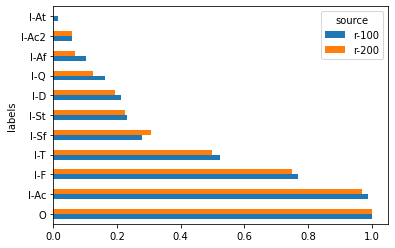

In [18]:
(df_tag_sentence_count / source_sentence_count).plot.barh()

### Most common tokens per tag

For each tag what is the most common tokens and their frequency.

In [19]:
topn = 10
import numpy as np

(df_train
 .groupby(['labels', 'tokens'])
 .agg(n=('index', 'count'), n_sentence=('index', 'nunique'), n_source=('source', 'nunique'))
 .sort_values('n', ascending=False)
 .reset_index()
 .groupby('labels')
 .pipe(lambda _: pd.DataFrame({**{f'token_{i}': np.where(_.n.nth(i) > 0, _.tokens.nth(i), '') for i in range(topn)}, **{f'prop_{i}': _.n.nth(i)/ _.n.sum() for i in range(topn)}}))
).style.format({f'prop_{i}': '{:0.2%}' for i in range(topn)})

,token_0,token_1,token_2,token_3,token_4,token_5,token_6,token_7,token_8,token_9,prop_0,prop_1,prop_2,prop_3,prop_4,prop_5,prop_6,prop_7,prop_8,prop_9
labels,,,,,,,,,,,,,,,,,,,,
I-Ac,Add,cook,stir,add,to,Place,Stir,Preheat,Pour,Bake,4.50%,2.47%,2.36%,2.34%,2.31%,2.26%,2.06%,1.83%,1.68%,1.55%
I-Ac2,to,boil,the,taste,out,together,make,coat,down,cover,34.93%,9.17%,8.30%,5.24%,4.80%,3.06%,3.06%,2.62%,2.18%,2.18%
I-Af,cool,to,has,rest,set,out,run,form,stand,marinate,11.40%,5.26%,3.07%,2.63%,2.63%,2.19%,2.19%,2.19%,1.75%,1.75%
I-At,out,comes,finish,finished,signals,up,go,heat,,,35.00%,35.00%,5.00%,5.00%,5.00%,5.00%,5.00%,5.00%,0.00%,0.00%
I-D,minutes,to,about,5,10,20,1,15,30,hours,26.82%,7.09%,7.01%,5.02%,4.58%,3.46%,3.20%,3.03%,3.03%,2.77%
I-F,mixture,water,oil,sugar,salt,sauce,chicken,pepper,butter,flour,3.55%,2.75%,2.61%,2.42%,2.26%,2.05%,2.02%,1.98%,1.95%,1.81%
O,.,the,",",and,a,in,with,to,until,for,15.09%,13.00%,10.20%,9.67%,5.50%,4.31%,2.88%,2.84%,2.61%,2.52%
I-Q,remaining,1,2,tablespoons,all,little,tablespoon,a,half,teaspoon,13.01%,6.39%,6.16%,4.79%,4.57%,4.34%,4.11%,3.65%,3.42%,2.97%
I-Sf,tender,golden,smooth,soft,hot,brown,browned,warm,cooked,fluffy,4.38%,3.54%,3.54%,3.44%,3.23%,3.02%,2.29%,1.88%,1.67%,1.67%


# Lengths

Most of these are very short and will easily fit into a context window

<AxesSubplot:title={'center':'n_tokens'}, xlabel='source'>

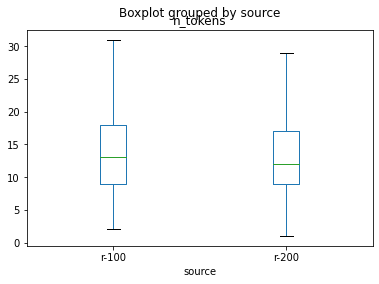

In [20]:
df_train_len = (df_train
 .groupby(['source', 'index'])
 .agg(n_tokens=('tokens', 'count'))
 .reset_index()
)

df_train_len.boxplot('n_tokens', by='source', grid=False, showfliers=False)

In [21]:
(df_train_len
 .groupby('source')
 .agg(min=('n_tokens', 'min'),
      med=('n_tokens', 'median'),
      mean=('n_tokens', 'mean'),
      max=('n_tokens', 'max'),
     )
)

,min,med,mean,max
source,,,,
r-100,2,13.0,13.925816,41
r-200,1,12.0,13.571317,47


## Common Tokens

In [22]:
(
    df_train
    .groupby('tokens')
    .agg(tag=('labels', pd.Series.mode), n=('index', 'count'))
    .sort_values('n', ascending=False)
    .assign(p = lambda _: _['n'] / sum(_['n']))
    .head(20)
)

,tag,n,p
tokens,,,
.,O,1957,0.073028
the,O,1749,0.065266
",",O,1325,0.049444
and,O,1266,0.047242
a,O,759,0.028323
to,O,644,0.024032
in,O,580,0.021643
with,O,373,0.013919
until,O,338,0.012613


# Preparing Model

In [23]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, DataCollatorForTokenClassification, Trainer
import torch

In [24]:
tag_feature = data['r-100']['train'].features['labels'].feature

In [25]:
tag_feature.num_classes

11

In [26]:
model_ckpt = 'xlm-roberta-base'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForTokenClassification.from_pretrained(model_ckpt, num_labels=tag_feature.num_classes).to(device)
collator = DataCollatorForTokenClassification(tokenizer)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-st

Let's run some examples

In [28]:
examples = data['r-100']['train'].select(range(2))

Tokenizing

In [30]:
examples[:]

{'tokens': [['Place',
   'the',
   'chicken',
   ',',
   'carrots',
   ',',
   'celery',
   'and',
   'onion',
   'in',
   'a',
   'large',
   'soup',
   'pot',
   ';',
   'cover',
   'with',
   'cold',
   'water',
   '.'],
  ['Heat',
   'and',
   'simmer',
   ',',
   'uncovered',
   ',',
   'until',
   'the',
   'chicken',
   'meat',
   'falls',
   'off',
   'of',
   'the',
   'bones',
   '(',
   'skim',
   'off',
   'foam',
   'every',
   'so',
   'often',
   ')',
   '.']],
 'labels': [[0, 6, 5, 6, 5, 6, 5, 6, 5, 6, 6, 9, 10, 10, 6, 0, 6, 8, 5, 6],
  [0, 6, 0, 6, 0, 6, 6, 6, 5, 5, 2, 2, 6, 6, 5, 6, 0, 0, 5, 6, 6, 6, 6, 6]]}

First we tokenize

In [31]:
inputs = tokenizer(examples['tokens'], is_split_into_words=True)
inputs

{'input_ids': [[0, 41076, 70, 143896, 6, 4, 37941, 933, 6, 4, 4157, 1294, 136, 98, 1830, 23, 10, 21334, 101084, 1540, 2819, 29256, 678, 91097, 7401, 6, 5, 2], [0, 1529, 257, 136, 78, 6947, 6, 4, 51, 63127, 297, 6, 4, 24189, 70, 143896, 163, 257, 123867, 5773, 111, 70, 32881, 7, 15, 6, 9851, 5773, 5775, 302, 11907, 221, 27983, 1388, 6, 5, 2]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [32]:
pd.DataFrame({'tokens': tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]),
              'word_ids': inputs.word_ids(0)}).T

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
tokens,<s>,▁Place,▁the,▁chicken,▁,",",▁carro,ts,▁,",",...,▁soup,▁pot,▁;,▁cover,▁with,▁cold,▁water,▁,.,</s>
word_ids,NaN,0.0,1.0,2.0,3.0,3.0,4.0,4.0,5.0,5.0,...,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,19.0,NaN


In [33]:
pd.DataFrame({'tokens': tokenizer.convert_ids_to_tokens(inputs['input_ids'][1]),
              'word_ids': inputs.word_ids(1)}).T

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
tokens,<s>,▁He,at,▁and,▁si,mmer,▁,",",▁un,cover,...,▁off,▁fo,am,▁every,▁so,▁often,▁),▁,.,</s>
word_ids,NaN,0.0,0.0,1.0,2.0,2.0,3.0,3.0,4.0,4.0,...,17.0,18.0,18.0,19.0,20.0,21.0,22.0,23.0,23.0,NaN


We need to realign the labels

In [34]:
IGN = -100
def align_labels(labels, word_ids):
    last_idx = None
    output = []
    for idx in word_ids:
        if idx is not None and idx != last_idx:
            output.append(labels[idx])
        else:
            output.append(IGN)
        last_idx = idx
    return output

In [35]:
(
    pd.DataFrame({'tokens': tokenizer.convert_ids_to_tokens(inputs['input_ids'][1]),
              'word_ids': inputs.word_ids(1),
              'labels': align_labels(examples['labels'][1], inputs.word_ids(1))}
            )
.assign(label_str = lambda _: [tag_feature.int2str(t) if t != -100 else 'IGN' for t in _.labels])
    .T
)

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
tokens,<s>,▁He,at,▁and,▁si,mmer,▁,",",▁un,cover,...,▁off,▁fo,am,▁every,▁so,▁often,▁),▁,.,</s>
word_ids,NaN,0.0,0.0,1.0,2.0,2.0,3.0,3.0,4.0,4.0,...,17.0,18.0,18.0,19.0,20.0,21.0,22.0,23.0,23.0,NaN
labels,-100,0,-100,6,0,-100,6,-100,0,-100,...,0,5,-100,6,6,6,6,6,-100,-100
label_str,IGN,I-Ac,IGN,O,I-Ac,IGN,O,IGN,I-Ac,IGN,...,I-Ac,I-F,IGN,O,O,O,O,O,IGN,IGN


Then we put it into the model

In [36]:
def tokenize_and_align(examples):
    tokenized_inputs = tokenizer(examples['tokens'], is_split_into_words=True, truncation=True)
    tokenized_inputs['labels'] = align_labels(examples['labels'], tokenized_inputs.word_ids())
    return tokenized_inputs

In [37]:
encoded_examples = examples.map(tokenize_and_align, remove_columns=['tokens'])

  0%|          | 0/2 [00:00<?, ?ex/s]

In [38]:
inputs = collator([encoded_examples[idx] for idx in range(2)], return_tensors='pt')
inputs

{'labels': tensor([[-100,    0,    6,    5,    6, -100,    5, -100,    6, -100,    5, -100,
             6,    5, -100,    6,    6,    9,   10,   10,    6,    0,    6,    8,
             5,    6, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
          -100],
         [-100,    0, -100,    6,    0, -100,    6, -100,    0, -100, -100,    6,
          -100,    6,    6,    5,    5, -100,    2,    2,    6,    6,    5, -100,
             6,    0, -100,    0,    5, -100,    6,    6,    6,    6,    6, -100,
          -100]]),
 'input_ids': tensor([[     0,  41076,     70, 143896,      6,      4,  37941,    933,      6,
               4,   4157,   1294,    136,     98,   1830,     23,     10,  21334,
          101084,   1540,   2819,  29256,    678,  91097,   7401,      6,      5,
               2,      1,      1,      1,      1,      1,      1,      1,      1,
               1],
         [     0,   1529,    257,    136,     78,   6947,      6,      4,     51,
           63127,   

In [39]:
label_ids = inputs['labels']
label_ids.shape

torch.Size([2, 37])

In [40]:
preds = model(input_ids=inputs['input_ids'].to(device), attention_mask=inputs['attention_mask'].to(device))

We get: bs x seq_length x num_labels

In [41]:
predictions = preds.logits
predictions.shape

torch.Size([2, 37, 11])

In [42]:
del model
del preds

In [44]:
data_encoded = {source: ds.map(tokenize_and_align, remove_columns=['tokens']) for source, ds in data.items()}

  0%|          | 0/674 [00:00<?, ?ex/s]

  0%|          | 0/150 [00:00<?, ?ex/s]

  0%|          | 0/148 [00:00<?, ?ex/s]

  0%|          | 0/1283 [00:00<?, ?ex/s]

  0%|          | 0/246 [00:00<?, ?ex/s]

  0%|          | 0/304 [00:00<?, ?ex/s]

## Evaluating a prediction

To evaluate our predictions we need to align them back with the original labels.
This is almost the inverse of padding with the -100 tags.

In [45]:
tag_feature

ClassLabel(num_classes=11, names=['I-Ac', 'I-Ac2', 'I-Af', 'I-At', 'I-D', 'I-F', 'O', 'I-Q', 'I-Sf', 'I-St', 'I-T'], names_file=None, id=None)

In [46]:
from itertools import compress
import numpy as np

def align_predictions(predictions, label_ids, int2str=tag_feature.names):
    preds = np.argmax(predictions, axis=-1)
    batch_size, seq_len = preds.shape
    
    y_true = []
    y_pred = []
    for pred, label in zip(preds, label_ids):
        mask = [l != IGN for l in label]
        y_true.append([int2str[l] for l in compress(label, mask)])
        y_pred.append([int2str[l] for l in compress(pred, mask)])
    
    return y_true, y_pred

In [47]:
y_true, y_pred = align_predictions(predictions.cpu().detach().numpy(), label_ids.cpu().detach().numpy())
y_true, y_pred

([['I-Ac',
   'O',
   'I-F',
   'O',
   'I-F',
   'O',
   'I-F',
   'O',
   'I-F',
   'O',
   'O',
   'I-St',
   'I-T',
   'I-T',
   'O',
   'I-Ac',
   'O',
   'I-Sf',
   'I-F',
   'O'],
  ['I-Ac',
   'O',
   'I-Ac',
   'O',
   'I-Ac',
   'O',
   'O',
   'O',
   'I-F',
   'I-F',
   'I-Af',
   'I-Af',
   'O',
   'O',
   'I-F',
   'O',
   'I-Ac',
   'I-Ac',
   'I-F',
   'O',
   'O',
   'O',
   'O',
   'O']],
 [['I-Ac2',
   'I-Ac2',
   'I-Ac2',
   'I-Ac2',
   'I-Af',
   'I-Ac2',
   'I-Ac2',
   'I-Ac2',
   'I-Ac2',
   'I-Ac2',
   'I-Ac2',
   'I-Ac2',
   'I-Ac2',
   'I-Ac2',
   'I-Ac2',
   'I-Ac2',
   'I-Ac2',
   'I-Ac2',
   'I-Ac2',
   'I-Ac2'],
  ['I-Ac2',
   'I-Ac2',
   'I-Ac2',
   'I-Ac2',
   'I-Ac2',
   'I-Ac2',
   'I-Ac2',
   'I-Ac2',
   'I-Ac2',
   'I-Ac2',
   'I-Ac2',
   'I-Ac2',
   'I-Ac2',
   'I-Ac2',
   'I-Ac2',
   'I-Ac2',
   'I-Ac2',
   'I-Ac2',
   'I-Ac2',
   'I-Ac2',
   'I-Ac2',
   'I-Ac2',
   'I-Ac2',
   'I-Ac2']])

In [48]:
from seqeval.metrics import f1_score

In [49]:
f1_score(y_true, y_pred)

0.0

# Baseline

A simple baseline is to assign each word to the most common tag.

Ideally I'd use the pipeline above, but it's a touch tricky.

In [50]:
most_common_token = df_train.groupby('tokens').agg(label=('labels', lambda x: pd.Series.mode(x)[0]))['label'].to_dict()

In [51]:
%%time
preds = {}
actual = {}
tokens = {}

eval_split = 'validation'

for source in data_sources:
    preds[source] = []
    actual[source] = []
    for item in data[source][eval_split]:
        actual[source].append(tag_feature.int2str(item['labels']))
        preds[source].append([most_common_token.get(t, 'O') for t in item['tokens']])

CPU times: user 42.9 ms, sys: 3.12 ms, total: 46 ms
Wall time: 44 ms


This simple model gives an f1 scores in the mid 70s.

In [52]:
for source in data_sources:
    print(source, f1_score(actual[source], preds[source]))

r-100 0.724341751746373
r-200 0.7667151162790699


Looking by label: the most common mistakes are mispredicting terms for "O", especially "I-F".

In [53]:
preds_flat = {source: [l for row in preds[source] for l in row] for source in data_sources}
actuals_flat = {source: [l for row in actual[source] for l in row] for source in data_sources}


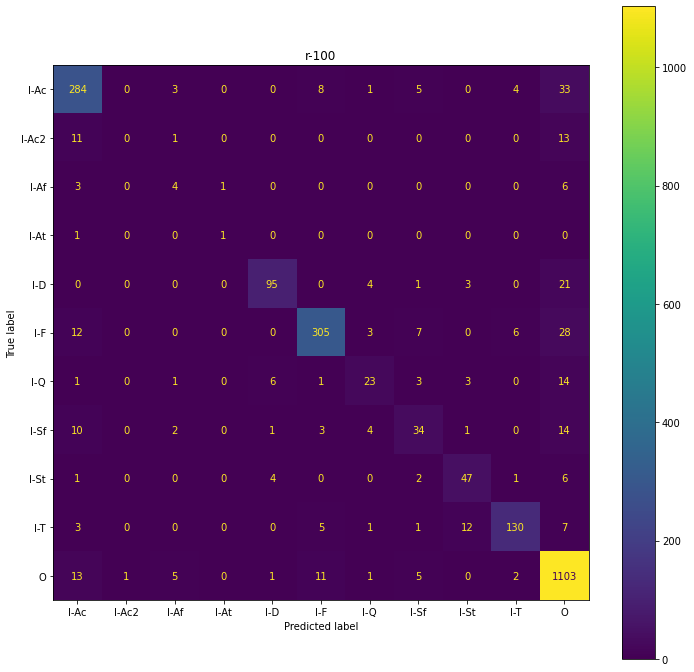

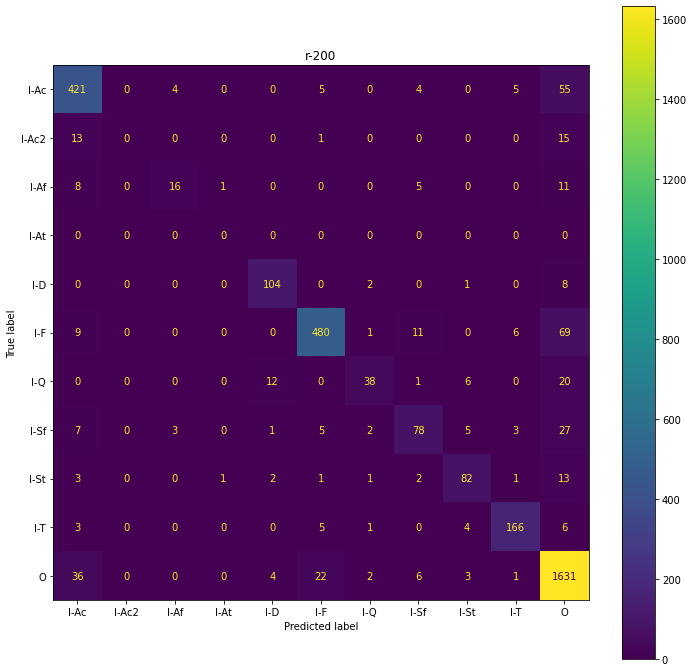

In [54]:
from sklearn.metrics import ConfusionMatrixDisplay

import matplotlib.pyplot as plt


for source in data_sources:
    fig, ax = plt.subplots(1, figsize=(12, 12))
    ax.set_title(source)
    ConfusionMatrixDisplay.from_predictions(actuals_flat[source], preds_flat[source], ax=ax)

What are the confused tags?

In [55]:
tokens_flat = {source: [t for s in data[source][eval_split]['tokens'] for t in s] for source in data_sources}

In [56]:
mismatch = []
for source in data_sources:
    for label, pred, token in zip(actuals_flat[source], preds_flat[source], tokens_flat[source]):
        if label != pred and label != 'O' and pred != 'O':
            mismatch.append((token, label, pred))

The most common mistake is whether '2' is a quantity or a duration.

In [57]:
(
    pd.DataFrame(mismatch, columns=['token', 'actual', 'pred'])
    .assign(n=1)
    .groupby(['token', 'actual', 'pred'])
    .count()
    .sort_values('n', ascending=False)
)

,,,n
token,actual,pred,
2,I-Q,I-D,10
mix,I-F,I-Ac,7
1,I-Q,I-D,6
4,I-Q,I-St,5
serving,I-T,I-Ac,5
...,...,...,...
flour,I-Ac,I-F,1
form,I-Ac,I-Af,1
four,I-Sf,I-Q,1


# Fit model

In [58]:
def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions, 
                                       eval_pred.label_ids)
    return {"f1": f1_score(y_true, y_pred)}

In [60]:
from transformers import TrainingArguments

source = 'r-200'
num_epochs = 3
batch_size = 12

logging_steps = len(data[source]["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-recipe-{source}"
training_args = TrainingArguments(
    output_dir=model_name, log_level="error", num_train_epochs=num_epochs, 
    per_device_train_batch_size=batch_size, 
    per_device_eval_batch_size=batch_size, evaluation_strategy="epoch", 
    save_steps=1e6, weight_decay=0.01, disable_tqdm=False, 
    logging_steps=logging_steps,
    push_to_hub=push_to_hub,
    report_to='none')

https://discuss.huggingface.co/t/change-label-names-on-inference-api/3063/3

In [61]:
def model_init():
    return AutoModelForTokenClassification.from_pretrained(model_ckpt,
                                                           num_labels=tag_feature.num_classes,
                                                           label2id={v:i for i,v in enumerate(tag_feature.names)},
                                                           id2label={i:v for i,v in enumerate(tag_feature.names)}).to(device)


In [63]:
def get_f1_score(trainer, dataset):
    return trainer.predict(dataset).metrics["test_f1"]

In [64]:
from transformers import Trainer
from typing import Dict

def train_on_dataset(dataset: DatasetDict, label: str, test_datasets: Dict[str, Dataset], test_training_args=training_args) -> Dict[str, float]:
    model_name = f"{model_ckpt}-finetuned-recipe-{label}"
    
    training_args.logging_steps = len(dataset['train']) // training_args.per_device_train_batch_size
    training_args.output_dir = model_name
    
    
    trainer = Trainer(model_init=model_init,
                  args=training_args, 
                  data_collator=collator,
                  compute_metrics=compute_metrics,
                  train_dataset=dataset["train"],
                  eval_dataset=dataset["validation"], 
                  tokenizer=tokenizer)
    trainer.train()
    if training_args.push_to_hub:
        trainer.push_to_hub(commit_message="Training completed!")
        
    return {name: get_f1_score(trainer, test_set) for name, test_set in test_datasets.items()}, trainer

In [65]:
from datasets import concatenate_datasets

In [66]:
test_datasets = {source: dataset['test'] for source, dataset in data_encoded.items()}
test_datasets['all'] = concatenate_datasets(test_datasets.values())

In [67]:
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


In [68]:
results = {}
for label, dataset in data_encoded.items():
    print(label)
    results[label], _ = train_on_dataset(dataset, label, test_datasets)

r-100


Epoch,Training Loss,Validation Loss,F1
1,0.786900,0.329160,0.810724
2,0.233000,0.271190,0.841653
3,0.171000,0.265800,0.850216


r-200


Epoch,Training Loss,Validation Loss,F1
1,0.616000,0.264427,0.843425
2,0.215000,0.200801,0.883873
3,0.144400,0.199026,0.892792


On the combined data

In [69]:
splits = list(next(iter(data.values())).keys())

splits

['train', 'validation', 'test']

In [70]:
dataset_all_encoded = DatasetDict(**{split: concatenate_datasets([data_encoded[source][split] for source in data]) for split in splits})

In [71]:
results['all'], trainer = train_on_dataset(dataset_all_encoded, 'all', test_datasets)

Epoch,Training Loss,Validation Loss,F1
1,0.471700,0.223126,0.866565
2,0.195300,0.207981,0.881674
3,0.131200,0.198678,0.891280


Here are our results.

In [72]:
results_df = pd.DataFrame(results)

results_df.style.format('{:0.4}')

,r-100,r-200,all
r-100,0.9257,0.882,0.9393
r-200,0.8415,0.9371,0.9426
all,0.87,0.9181,0.9415


# Model Examples

In [73]:
def align_token_preds(inputs, tokens, preds):
    results = []
    for idx in range(inputs['input_ids'].shape[0]):
        result = []
        for key, group in groupby(zip(inputs.word_ids(idx), tokens[idx], preds[idx]), key=lambda x: x[0]):
            if key is not None:
                group = list(group)
                token = ''.join([x[1] for x in group]).lstrip('▁')
                tag = group[0][2]
                result.append((token, tag))
        results.append(list(zip(*result)))
    return results

In [74]:
def show_preds(text):
    inputs = tokenizer(text, return_tensors="pt")
    tokens = [tokenizer.convert_ids_to_tokens(x) for x in inputs['input_ids']]
    preds = [tag_feature.int2str(x) for x in trainer.model(**inputs.to(device)).logits.argmax(axis=-1)]
    return pd.DataFrame([tokens[0], preds[0]], index=['token', 'pred']).iloc[:, 1:-1]

In [75]:
show_preds("4 cloves of garlic")

,1,2,3,4,5,6
token,▁4,▁clo,ves,▁of,▁gar,lic
pred,I-Q,I-F,I-F,O,I-F,I-F


In [76]:
show_preds("2 x 400g tins of quality plum tomatoes")

,1,2,3,4,5,6,7,8,9,10,11,12
token,▁2,▁x,▁400,g,▁tin,s,▁of,▁quality,▁plu,m,▁tomato,es
pred,I-Q,O,I-Q,I-Q,I-T,O,O,I-St,I-F,I-F,I-F,I-F


In [77]:
show_preds("Measure and add the flour, sugar, baking powder, and salt to the mixing bowl")

,1,2,3,4,5,6,7,8,9,10,...,13,14,15,16,17,18,19,20,21,22
token,▁Me,a,sure,▁and,▁add,▁the,▁flo,ur,",",▁sugar,...,ing,▁powder,",",▁and,▁salt,▁to,▁the,▁mix,ing,▁bowl
pred,I-Ac,I-Ac,I-Ac,O,I-Ac,O,I-F,I-F,O,I-F,...,I-F,I-F,O,O,I-F,O,O,I-T,I-T,I-T


In [78]:
show_preds("Microwave the mug and batter on high power for 60 seconds")

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
token,▁Micro,wa,ve,▁the,▁mu,g,▁and,▁bat,ter,▁on,▁high,▁power,▁for,▁60,▁seconds
pred,I-Ac,I-Ac,I-Ac,O,I-F,I-F,O,I-F,I-F,O,I-St,I-T,O,I-D,I-D


# Error Analysis

Let's follow the book to get the validation data with losses in a nice format

In [79]:
from torch.nn.functional import cross_entropy


def forward_pass_with_label(batch, data_collator=collator, trainer=trainer):
    # Convert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # Pad inputs and labels and put all tensors on device
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    with torch.no_grad():
        # Pass data through model  
        output = trainer.model(input_ids, attention_mask)
        # Logit.size: [batch_size, sequence_length, classes]
        # Predict class with largest logit value on classes axis
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
    # Calculate loss per token after flattening batch dimension with view
    loss = cross_entropy(output.logits.view(-1, trainer.model.num_labels), 
                         labels.view(-1), reduction="none")
    # Unflatten batch dimension and convert to numpy array
    loss = loss.view(len(input_ids), -1).cpu().numpy()

    return {"loss":loss, "predicted_label": predicted_label}

In [80]:
valid_set = dataset_all_encoded['validation'].map(forward_pass_with_label, batched=True, batch_size=32)

Parameter 'function'=<function forward_pass_with_label at 0x146fbec20> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/13 [00:00<?, ?ba/s]

In [81]:
df = valid_set.to_pandas()

In [82]:
index2tag = {i: v for i, v in enumerate(tag_feature.names)}
index2tag[-100] = 'IGN'

In [83]:
df['input_tokens'] = df['input_ids'].apply(tokenizer.convert_ids_to_tokens)
df['predicted_label'] = df['predicted_label'].apply(lambda x: [index2tag[i] for i in x])
df['labels'] = df['labels'].apply(lambda x: [index2tag[i] for i in x])
df['loss'] = df.apply(lambda x: x['loss'][:len(x['input_ids'])], axis=1)
df['predicted_label'] = df.apply(lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)

In [84]:
df.head(1)

,attention_mask,input_ids,labels,loss,predicted_label,input_tokens
0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0, 1529, 257, 29700, 23, 10, 21334, 31837, 78...","[IGN, I-Ac, IGN, I-F, O, O, I-St, I-T, IGN, O,...","[0.0, 0.0012535341, 0.0, 0.0036887953, 0.00054...","[I-T, I-Ac, I-Ac, I-F, O, O, I-St, I-T, I-T, O...","[<s>, ▁He, at, ▁oil, ▁in, ▁a, ▁large, ▁stock, ..."


In [85]:
df_tokens =   (df
    .apply(pd.Series.explode)
    .reset_index()
    .query('input_tokens not in ("<s>", "</s>")')
   )

df_tokens['word_idx'] = (df_tokens
                         .assign(start = lambda _: np.where(_['labels'] != 'IGN', 1, 0))
                         .groupby('index')
                         ['start']
                         .cumsum())

df_tokens = (
    df_tokens
    .groupby(['index', 'word_idx'])
    .agg(loss=('loss', 'first'),
         label=('labels', 'first'),
         subtoken=('input_tokens', 'first'),
         token=('input_tokens', lambda x: ''.join(x).lstrip('▁'))))

df_tokens.head()

loss label subtoken  token
index word_idx                                
0     1         0.001254  I-Ac      ▁He   Heat
      2         0.003689   I-F     ▁oil    oil
      3         0.000540     O      ▁in     in
      4         0.000497     O       ▁a      a
      5         0.007716  I-St   ▁large  large

## Tokens with most loss

In [86]:
(
    df_tokens
    .groupby('token')
    .agg(total_loss=('loss', 'sum'),
         avg_loss=('loss', 'mean'),
         n=('loss', 'count'),
         typical_label=('label', pd.Series.mode),)
    .sort_values('total_loss', ascending=False)
    .head(10)
).T

token,to,a,it,each,together,boiling,some,all,the,them
total_loss,61.929745,25.990784,24.090071,21.765989,20.736488,19.44034,18.793659,16.626747,13.441703,13.43555
avg_loss,0.410131,0.15752,1.417063,1.451066,1.091394,2.777191,1.174604,2.078343,0.033944,1.492839
n,151,165,17,15,19,7,16,8,396,9
typical_label,O,O,I-F,O,O,I-Ac,O,"[I-F, O]",O,I-F


Let's look at 1

In [87]:
df_tokens.query('token=="1"').groupby('label').agg(n=('loss', 'count'), loss=('loss', 'mean'))

,n,loss
label,,
I-D,7,0.003018
I-Q,6,0.012636
I-Sf,1,0.079706


Looking at some examples these all contain an "or" followed by a second ingredient.
In fact it's an issue in the data annotation process of only annotating the first ingredient.

In [88]:
from IPython.display import display
pd.options.display.max_columns = 50

def show_n_examples(token, label, n=5):

    idxs = (df_tokens
            .loc[((df_tokens.token == token) & (df_tokens.label == label))]
            .reset_index()
            ['index'])

    for idx in idxs[:n]:
        display(df_tokens.reset_index().set_index('index').loc[idx].set_index('token')[['label', 'loss']].T)
        
show_n_examples('1', 'O')

Let's try to find some other kinds of errors

In [89]:
high_loss_tokens = ['chopped', 'can', 'teaspoon', 'cracked', 
                    'firm', 'cloves', 'stewing', 'whole', 'juice']

In [90]:
(
    df_tokens
    .query('token in @high_loss_tokens & label != "O"')
    .groupby(['token', 'label'])
    .agg(n=('loss', 'count'),
         loss=('loss', 'mean'))
).T

token   chopped    cloves      firm      juice  teaspoon                    
label      I-Ac       I-F      I-Sf        I-F       I-Q      I-Sf       I-T
n      5.000000  1.000000  2.000000  13.000000  2.000000  1.000000  1.000000
loss   0.007693  0.002291  0.007135   0.003872  0.006714  0.159667  3.894341

The model is struggling to disambiguate "clove of garlic" from "ground cloves"

In [91]:
show_n_examples('cloves', 'I-UNIT')
show_n_examples('cloves', 'I-NAME')

Direct contridictions in how `firm` is labelled for both tofu and tomatoes.

In [92]:
show_n_examples('firm', 'I-STATE')
show_n_examples('firm', 'I-NAME')

Here's a direct contradiction; "stewing" in "stewing beef" is a name.

In [93]:
show_n_examples('stewing', 'I-STATE')
show_n_examples('stewing', 'I-NAME')

## Labels with most loss

'At' and 'Ac2' have the most loss, but also the fewest examples to learn from.

In [94]:
(df_tokens
 .groupby('label')
 .agg(n=('loss', 'count'),
      total_loss=('loss', 'sum'),
      avg_loss=('loss', 'mean'))
 .sort_values('avg_loss', ascending=False)
).T

label,I-At,I-Ac2,I-Af,I-Sf,I-Q,I-St,I-Ac,I-T,I-F,I-D,O
n,2.000000,54.000000,55.000000,200.000000,129.000000,167.000000,832.000000,344.000000,937.000000,239.000000,2847.000000
total_loss,4.543103,69.433289,60.117783,155.744293,51.387863,54.371807,197.350098,81.353485,179.852097,26.321278,279.330078
avg_loss,2.271552,1.285802,1.093051,0.778721,0.398356,0.325580,0.237200,0.236493,0.191945,0.110131,0.098114


## Ingredients with highest loss

Calculate the loss by ingredient

In [95]:
total_loss = (
    df_tokens
    .reset_index()
    .groupby('index')
    ['loss']
    .sum()
    .rename('total_loss')
)

df_tokens = df_tokens.merge(total_loss, left_index=True, right_index=True)

In [96]:
top_loss_ingredients = total_loss.sort_values(ascending=False)

top_loss_ingredients.head()

index
194    39.476460
27     29.228809
314    22.269766
189    20.453314
72     19.472752
Name: total_loss, dtype: float32

In [97]:
def show_idx(idx):
    return (
        pd.DataFrame(df.iloc[idx])
        .T
        .apply(pd.Series.explode)
        .set_index('input_tokens')
        [['loss', 'labels', 'predicted_label']]
        .iloc[1:-1]
        .T
    )

This is an example where multiple ingredients are annotated. This differs from many other examples we saw above where only the first ingredient is annotated.

In [98]:
show_idx(top_loss_ingredients.index[0])

input_tokens,▁If,▁you,▁did,',nt,▁use,▁a,▁silicone,▁mo,uld,▁,",",▁immer,se,▁the,▁mo,uld,▁in,▁bo,iling,▁water,▁then,▁turn,▁it,▁over,▁-,▁it,▁should,▁release,▁,.
loss,0.001002,0.001328,0.002742,0.0,0.0,0.01401,0.001315,0.040105,0.046655,0.0,0.000481,0.0,6.509859,0.0,0.000991,5.762336,0.0,0.00111,6.082448,0.0,5.818228,0.000852,6.465014,4.543209,0.979661,0.000922,0.235307,0.010047,2.958363,0.000477,0.0
labels,O,O,O,IGN,IGN,O,O,O,O,IGN,O,IGN,O,IGN,O,O,IGN,O,O,IGN,O,O,O,O,O,O,I-F,O,I-Ac,O,IGN
predicted_label,O,O,O,O,O,O,O,O,O,O,O,O,I-Ac,I-Ac,O,I-F,I-F,O,I-Ac,I-Sf,I-F,O,I-Ac,I-F,O,O,I-F,O,I-Af,O,O


This is ambiguous; should both of the quantities be annotated?

In [99]:
show_idx(top_loss_ingredients.index[1])

input_tokens,▁Divi,de,▁the,▁do,ugh,▁into,▁10,▁equal,▁pieces,▁,",",▁and,▁form,▁into,▁round,s,▁,.
loss,0.001748,0.0,0.00092,0.002672,0.0,0.001744,3.233749,5.449229,6.16696,0.000448,0.0,0.001148,0.004285,6.606344,7.759114,0.0,0.000448,0.0
labels,I-Ac,IGN,O,I-F,IGN,O,I-Q,I-Q,I-Q,O,IGN,O,I-Ac,I-Ac,I-Ac,IGN,O,IGN
predicted_label,I-Ac,I-Ac,O,I-F,I-F,O,I-Sf,I-Sf,I-Sf,O,O,O,I-Ac,O,I-Sf,I-Sf,O,O


So much is wrong here:

* whole is not a unit; it's a kind of milk (this is tricky to annotate, the kind of example that breaks NER!)
* 2% is not a state

In [100]:
show_idx(top_loss_ingredients.index[2])

input_tokens,▁Re,duce,▁heat,▁to,▁low,▁,",",▁and,▁si,mmer,▁for,▁about,▁30,▁minutes,▁,",",▁adding,▁more,▁water,▁if,▁necessary,▁to,▁keep,▁the,▁mix,ture,▁from,▁dry,ing,▁out,▁,.
loss,0.00114,0.0,0.00456,0.00327,0.016813,0.000446,0.0,0.000928,0.00286,0.0,0.001342,0.003278,0.001463,0.001533,0.000444,0.0,0.018487,1.827135,0.011303,0.000724,0.006368,0.094971,4.341193,0.001407,0.208675,0.0,6.775388,4.964667,0.0,3.980938,0.000433,0.0
labels,I-Ac,IGN,I-T,O,I-St,O,IGN,O,I-Ac,IGN,O,I-D,I-D,I-D,O,IGN,I-Ac,O,I-F,O,O,O,I-Ac,O,I-F,IGN,I-Ac2,I-Ac2,IGN,I-Ac2,O,IGN
predicted_label,I-Ac,I-Ac,I-T,O,I-St,O,O,O,I-Ac,I-Ac,O,I-D,I-D,I-D,O,O,I-Ac,I-Q,I-F,O,O,O,O,O,I-F,I-F,O,O,O,O,O,O


The annotation here is right, but the predictions only picks up the first ingredient.

In [101]:
show_idx(top_loss_ingredients.index[3])

input_tokens,▁Pour,▁approximately,▁1,cm,▁of,▁the,▁cream,▁mix,ture,▁into,▁a,▁mo,uld,▁and,▁refrigera,te,▁,.
loss,0.001089,0.752207,4.30168,0.0,0.001859,0.000851,7.515005,7.845748,0.0,0.00349,0.001327,0.024211,0.0,0.000631,0.004783,0.0,0.000432,0.0
labels,I-Ac,O,I-Sf,IGN,O,O,I-T,I-T,IGN,O,O,I-T,IGN,O,I-Ac,IGN,O,IGN
predicted_label,I-Ac,I-Q,I-Q,I-Q,O,O,I-F,I-F,I-F,O,O,I-T,I-T,O,I-Ac,I-Ac,O,O


This is an annotation issue; peeled and sliced is a STATE and not a SIZE.

In [102]:
show_idx(top_loss_ingredients.index[4])

input_tokens,▁It,▁',s,▁important,▁to,▁brown,▁the,▁sa,usage,s,▁first,▁in,▁a,▁large,▁fry,ing,▁pan,▁to,▁get,▁some,▁fl,avour,▁going,▁(,▁use,▁a,▁little,▁olive,▁oil,▁in,▁the,▁pan,▁to,▁get,▁them,▁going,▁),▁,.
loss,0.001575,0.002853,0.0,0.008519,0.01272,0.043913,0.001085,0.031784,0.0,0.0,0.002317,0.000591,0.000597,0.010156,0.005197,0.0,0.005924,0.093029,2.286455,0.031325,0.596977,0.0,1.900733,0.000719,1.117603,0.029897,0.32338,0.710528,0.960548,0.00081,0.000929,1.22876,0.065904,3.658761,4.174461,2.163631,0.000607,0.000463,0.0
labels,O,O,IGN,O,O,I-Ac,O,I-F,IGN,IGN,O,O,O,I-St,I-T,IGN,I-T,O,I-Ac,O,I-F,IGN,I-Af,O,I-Ac,O,I-Q,I-F,I-F,O,O,I-T,O,I-Ac,I-F,I-Af,O,O,IGN
predicted_label,O,O,O,O,O,I-Ac,O,I-F,I-F,I-F,O,O,O,I-St,I-T,I-T,I-T,O,O,O,I-F,I-F,O,O,O,O,I-Q,I-F,O,O,O,O,O,O,O,O,O,O,O


Again the annotatoin is wrong here:

* can is not a unit
* for some reason only 2 or the 3 alternative ingredients are annotated...

In [103]:
show_idx(top_loss_ingredients.index[5])

input_tokens,▁Mix,▁the,▁flo,ur,▁,",",▁remain,ing,▁sugar,▁and,▁the,▁butter,▁with,▁your,▁finger,s,▁in,▁a,▁bowl,▁until,▁it,▁become,s,▁like,▁a,▁bread,cru,mb,▁consiste,ncy,▁,.
loss,0.001825,0.000886,0.001662,0.0,0.000657,0.0,6.364434,0.0,0.001612,0.000802,0.000896,0.001498,0.000818,0.005915,0.12029,0.0,0.000674,0.000823,0.002409,0.000891,4.824533,3.024389,0.0,0.936348,0.37356,0.06331,0.0,0.0,3.274525,0.0,0.000494,0.0
labels,I-Ac,O,I-F,IGN,O,IGN,I-F,IGN,I-F,O,O,I-F,O,O,I-T,IGN,O,O,I-T,O,O,O,IGN,O,O,I-Sf,IGN,IGN,O,IGN,O,IGN
predicted_label,I-Ac,O,I-F,I-F,O,O,I-Q,I-Q,I-F,O,O,I-F,O,O,I-T,I-T,O,O,I-T,O,I-F,I-Af,I-Af,I-Sf,O,I-Sf,I-Sf,I-Sf,I-Sf,I-Sf,O,O


# Zero-shot Cross language transfer

Let's see if it's learned anything about different languages

In English:

In [104]:
show_preds("Measure and add the oil, water, and vanilla to the bowl.")

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
token,▁Me,a,sure,▁and,▁add,▁the,▁oil,",",▁water,",",▁and,▁van,illa,▁to,▁the,▁bowl,.
pred,I-Ac,I-Ac,I-Ac,O,I-Ac,O,I-F,O,I-F,O,O,I-F,I-F,O,O,I-T,O


In Spanish:

```
Mida y agregue el aceite, el agua y la vainilla al tazón.
```

This is incredible!

In [105]:
show_preds("Mida y agregue el aceite, el agua y la vainilla al tazón.")

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
token,▁Mida,▁y,▁agre,gue,▁el,▁aceite,",",▁el,▁agua,▁y,▁la,▁vain,illa,▁al,▁ta,zón,.
pred,I-Ac,O,I-Ac,I-Ac,O,I-F,O,O,I-F,O,O,I-F,I-F,O,I-T,I-T,O


In English

In Portuguese, it gets it right.

```
Meça e adicione o óleo, água e baunilha na tigela.
```

In [106]:
show_preds("Meça e adicione o óleo, água e baunilha na tigela.")

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
token,▁Me,ça,▁e,▁adi,cione,▁o,▁óleo,",",▁água,▁e,▁ba,un,ilha,▁na,▁,tige,la,.
pred,I-Ac,I-Ac,O,I-Ac,I-Ac,O,I-F,O,I-F,O,I-F,I-F,I-F,O,I-T,I-T,I-T,O


In [109]:
show_preds("Let the coffee drain completely into the mug before removing the dripper.")

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
token,▁Let,▁the,▁coffee,▁dra,in,▁completely,▁into,▁the,▁mu,g,▁before,▁remo,ving,▁the,▁dri,pper,.
pred,I-Ac,O,I-F,I-Af,I-Af,O,O,O,I-T,I-T,O,I-Ac,O,O,I-F,I-F,O


In [108]:
trainer.save_model('/Users/rlopez/PTG/experiments/models/xlm-roberta-base-finetuned/recipe_flow_graph')